# Exercises: The Lucas Tree Model of Asset Pricing

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import os
from scipy import optimize as opt

In [2]:
#loading the data
missing_values = ["n/a", "na", "."]
consumption = pd.read_csv("PCECC96.csv", na_values = missing_values, index_col=0).dropna()
consumption = consumption.set_index(pd.to_datetime(consumption.index)).resample("Q").first()
Sindex = pd.read_csv('WILL5000INDFC.csv', na_values = missing_values, index_col=0).dropna()
Sindex = Sindex.set_index(pd.to_datetime(Sindex.index)).resample("Q").first()
GDPdef = pd.read_csv('GDPDEF.csv', na_values = missing_values, index_col=0).dropna()
GDPdef = GDPdef.set_index(pd.to_datetime(GDPdef.index)).resample("Q").first()
TB = pd.read_csv('TB3MS.csv', na_values = missing_values, index_col=0).dropna()
TB = TB.set_index(pd.to_datetime(TB.index)).resample("Q").first()

In [3]:
#harmonizing dates
consumption=consumption['1971-03-31':'2018-03-31']
Sindex=Sindex['1971-03-31':'2018-03-31']
GDPdef=GDPdef['1971-03-31':'2018-03-31']
TB=TB['1971-03-31':'2018-03-31']

In [4]:
#cleaning
#Sindex_real=Sindex/(GDPdef/100)
GDPdef_2=GDPdef/100
GDPdef_2
Sindex_real= pd.DataFrame(Sindex['WILL5000INDFC'][:]/GDPdef_2['GDPDEF'][:], columns =["Sreal"]) # direct division did not work...
Return= Sindex_real/Sindex_real.shift(1)
rf=TB/100

In [5]:
df = pd.concat([consumption, GDPdef_2, Return, rf], axis=1, join='inner')
df.columns = ['c', 'GDPdef', 'SReturn', 'rf']

## Question 1

In [6]:
def obj_function(gamma, params):
    beta, df= params
    uprime= df['c']**(-gamma)
    df['mt'] = beta * uprime/uprime.shift(1)
    cov=np.cov(df['mt'][1:],(df['SReturn'][1:]))[0,1]
    error= 1-cov-df['mt'].mean()*df['SReturn'].mean()
    return error

In [7]:
beta = .99
guess_gamma=1.7
params=[beta, df]

In [8]:
result = opt.root(obj_function, guess_gamma, args=params)
est_gamma=result.x
est_gamma

array([1.32969261])

## Question 2

A gamma of 1.32969261 seems to be a reasonable result for a CRRA utility function. 

## Question 3

In [9]:
def obj_function2(gamma, params):
    beta, df= params
    uprime= df['c']**(-gamma)
    df['mt'] = beta * uprime/uprime.shift(1)
    error = np.mean((1+df['rf']-1/df['mt']))
    return error

In [10]:
result2 = opt.root(obj_function2, guess_gamma, args=params)
est_gamma2=result2.x
est_gamma2

array([4.7604495])

Huge difference to our result from question 1, even if they are supposed to result in the same thing (puzzle we talked about in class).

## Question 4

In [11]:
def obj_function3(params, df):
    gamma, beta= params
    moment= np.zeros((2))   
    Wmat=np.eye(2)
    
    #eq 1
    uprime= df['c']**(-gamma)
    df['mt'] = beta * uprime/uprime.shift(1)
    cov=np.cov(df['mt'][1:],(df['SReturn'][1:]))[0,1]
    moment[0]= 1-cov-df['mt'].mean()*df['SReturn'].mean()
    #eq 2:
    moment[1] =np.mean((1+df['rf']-1/df['mt']))  
    
    return moment.T@ Wmat @ moment

In [12]:
results= opt.minimize(obj_function3, [2, 1], args=df)
results

      fun: 0.0003479347702190418
 hess_inv: array([[0.9999574 , 0.00569122],
       [0.00569122, 0.23916224]])
      jac: array([-5.60612534e-08,  3.66781023e-08])
  message: 'Optimization terminated successfully.'
     nfev: 20
      nit: 3
     njev: 5
   status: 0
  success: True
        x: array([2.00013837, 0.98158236])

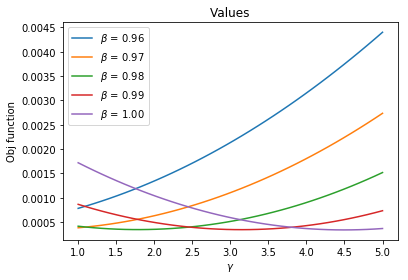

In [13]:
n = 40
N = 5
gamma_grid= np.linspace(1,5,n)
beta_grid= np.linspace(0.96,1,N)
values= np.zeros((n, N))
for ii in range(n):
    for jj in range(N):
        params=[gamma_grid[ii], beta_grid[jj]]
        values[ii,jj]= obj_function3(params, df)

plt.figure()
for jj in range(N):
    plt.plot(gamma_grid, values[:, jj], label=rf'$\beta$ = {beta_grid[jj]:.2f}')
plt.title('Values')
plt.xlabel('$\gamma$')
plt.ylabel('Obj function')
plt.legend()
plt.show();

# Exercises: Orderbooks and Asset Pricing

## Exercise 1

In [18]:
import pickle
import scipy.stats as sts

In [15]:
#converted all files to unix before starting
C = pickle.load(open('C', 'rb'))
GBX = pickle.load(open('GBX', 'rb'))
SPY = pickle.load(open('SPY', 'rb'))
THO = pickle.load(open('THO', 'rb'))
AAPL = pickle.load(open('AAPL', 'rb'))

In [16]:
class Orderbook:
    def __init__(self, data, name):
        self.name = name
        self.time = data[0]
        df = pd.DataFrame.from_dict(data[1], orient='index')
        
        # tbh didn't figure the following 9 lines out for hours, therefore got help from last year's repo (matt)
        # sorry for that but i really wanted to get further than this line
        df = df.sort_index()
        df = df.reset_index()
        df.columns = ['Price', 'Quantity', 'Side', 'red1','red2']
        df = df.drop(['red1', 'red2'], axis = 1) # dropping redundant data

        df['Q'] = df['Quantity'].cumsum() 
        Qm = np.max(df['Q'][df['Side']== 'B'])
        Pm = df['Price'][(df['Q'][df['Side']== 'B']).idxmax()]
        df['Q'] = df['Q'] - Qm
        self.Pm = Pm #midpoint
        
        #subset of order book
        self.df = df[(df['Price'] >= self.Pm*.90)  & (df['Price'] <= self.Pm*1.10)]
        
    def OLS(self, df):       
        beta, gamma, r_value, p_value, std_err = sts.linregress(df['Price'], df['Q'])
        estimation= gamma + beta * self.df['Price']
        est_mid= -gamma/beta
        Pdiff= est_mid-self.Pm
        return gamma, beta, estimation, est_mid, Pdiff
    
    def plot(self):
        gamma_e, beta_e, est, est_mid, Pdiff = self.OLS(self.df)
        print("Estimated Midpoint Price: "+ str(est_mid))
        print("Midpoint Price: "+str(self.Pm))
        s_d=np.linspace(0,0,len(self.df['Price'])) #where supply = demand

        plt.plot(self.df['Price'], self.df['Q'], label = 'Orderbook')  
        plt.plot(self.df['Price'], est)
        plt.plot(self.df['Price'], s_d, linestyle='dashed', linewidth=1)
        plt.title(f'{self.name}')
        plt.xlabel('Price')
        plt.ylabel('Qty')
        plt.xlim(self.df['Price'].min(), self.df['Price'].max())
        plt.ylim(self.df['Q'].min() * 1.2, self.df['Q'].max() * 1.2)
        plt.legend()
        plt.show()

Estimated Midpoint Price: 148.40664489697502
Midpoint Price: 145.14


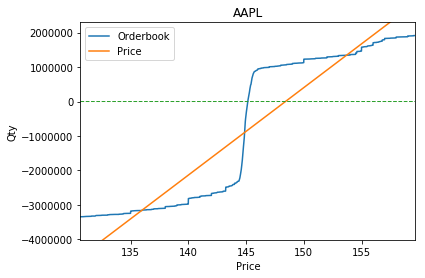

In [19]:
OB = Orderbook(AAPL[200], 'AAPL')
OB.plot()

Estimated Midpoint Price: 64.73274713859884
Midpoint Price: 66.77


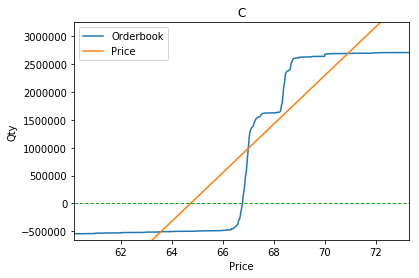

In [20]:
OB = Orderbook(C[200], 'C')
OB.plot()

Estimated Midpoint Price: 42.38601421333116
Midpoint Price: 43.2


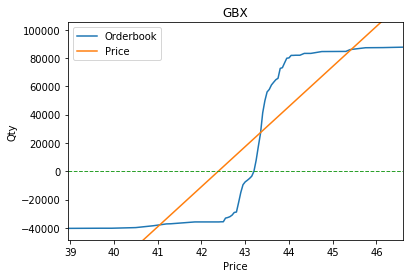

In [21]:
OB = Orderbook(GBX[200], 'GBX')
OB.plot()

Estimated Midpoint Price: 102.37337753074848
Midpoint Price: 102.37


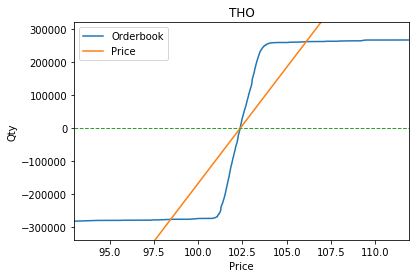

In [22]:
OB = Orderbook(THO[200], 'THO')
OB.plot()

Estimated Midpoint Price: 237.12290757268335
Midpoint Price: 241.82


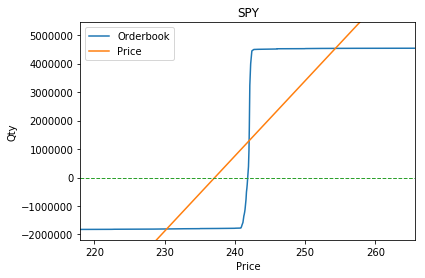

In [23]:
OB = Orderbook(SPY[200], 'SPY')
OB.plot()

Whether the estimation fits the actual order book depends on the stock, but it's mostly not fitting very well, even if i've already just looked at a subset of the orderbook.

## Exercise 2 & 3

The ratio corresponds to the betas

In [24]:
def get_beta_intraday(data, name):
    beta_intraday=np.zeros(len(data), dtype=np.float64)
    Pdiff=np.zeros(len(data), dtype=np.float64)

    for ii in range(len(data)):
        OB = Orderbook(data[ii], name)
        beta_intraday[ii]= OB.OLS(OB.df)[1]
        Pdiff[ii]= OB.OLS(OB.df)[4]
        
    fig, ax = plt.subplots(2, 1, figsize=(10,10))
    fig.suptitle(f'{name}')
    ax[0].plot(beta_intraday)
    ax[0].set_xlabel("Seconds")
    ax[0].set_ylabel(r'$\frac{2\sigma_u}{\sqrt{\Sigma_0}}$')
    
    ax[1].plot(Pdiff)
    ax[1].set_xlabel("Seconds")
    ax[1].set_ylabel('Difference in Midpoint Prices')

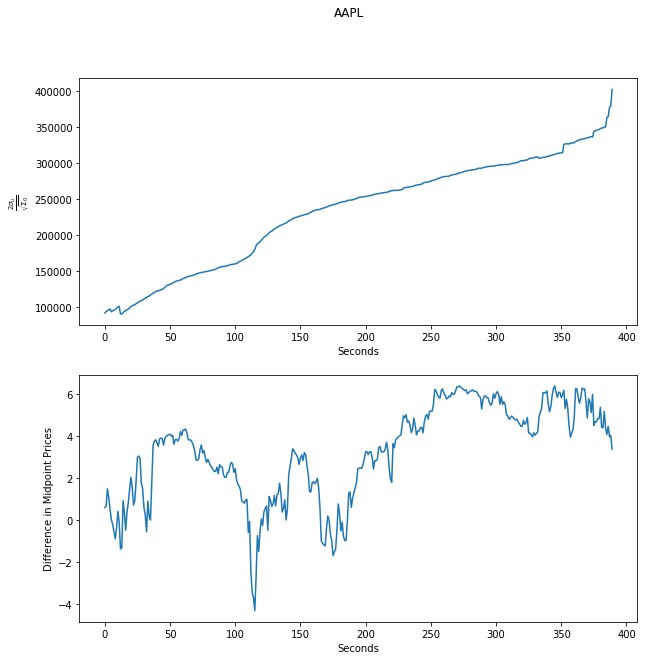

In [25]:
get_beta_intraday(AAPL, 'AAPL')

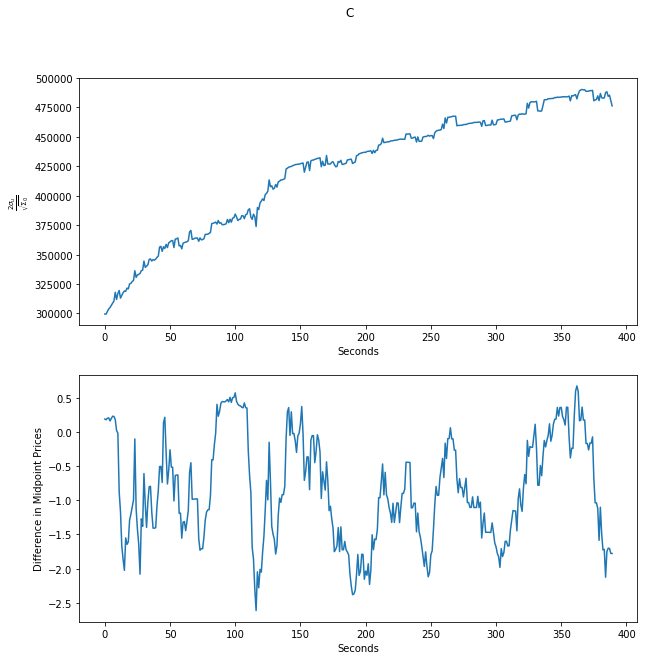

In [26]:
get_beta_intraday(C, 'C')

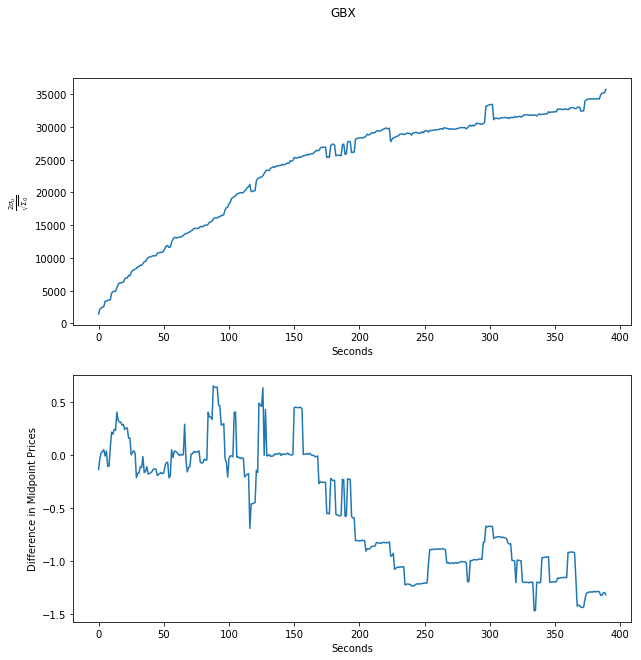

In [27]:
get_beta_intraday(GBX, 'GBX')

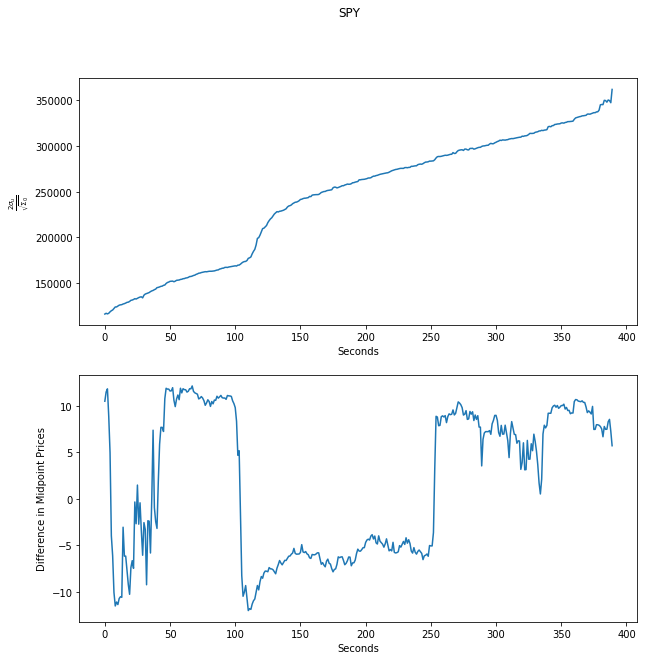

In [28]:
get_beta_intraday(SPY, 'SPY')

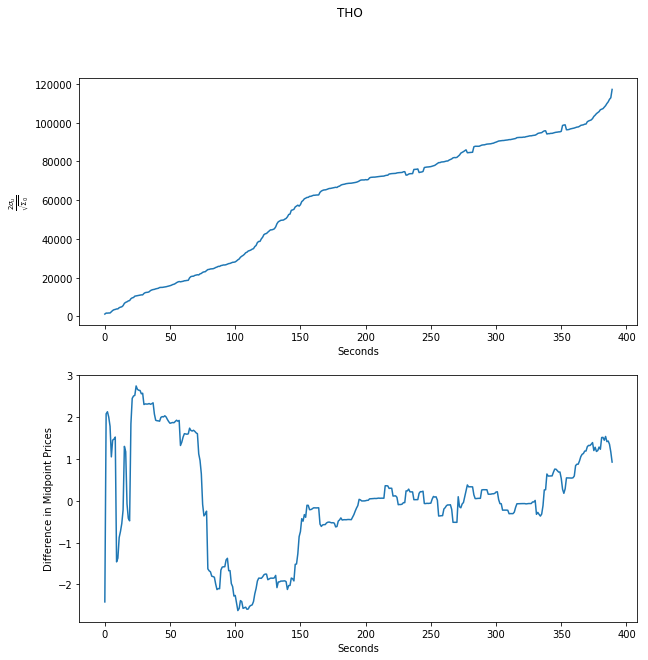

In [29]:
get_beta_intraday(THO, 'THO')

It seems like often the estimation procedure manages to estimate the real prices quite well for parts of the day, while in other parts of the day, the estimation is completely off. 

## Exercise 4

The noise/signal ratios are fullfilling my expectations. If I remember correctly, we discussed in class that throughout the day, the ration increases, which is also the case with these 5 stocks. However, as the ratio increases i would expect the difference between the estimated and the true midpoint prices to increase, which does not happend with all the stocks. 